# DOCKSTRING figures

## Table of Contents
- [Parity plots](#parity-plots)
- [Bar charts](#bar-charts)
- [CSVs](#csvs)

**NOTE:** This notebook assumes you have organized your processed DOCKSTRING datasets like so (ordering of the datasets themselves doesn't matter):
```
DOCKSTRING_DATASETS_ROOT
├── 0.001
│   ├── full
│   │   ├── abl1-top250.pkl
│   │   ├── ache-top250.pkl
│   │  ...
│   │   └── thrb-top250.pkl
│   └── prune
│   │   ├── abl1-top250.pkl
│   │   ├── ache-top250.pkl
│   │  ...
│   │   └── thrb-top250.pkl
├── 0.002
│   ├── full
│   └── prune
└── 0.004
    ├── full
    └── prune
```

In [18]:
from pathlib import Path
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind_from_stats
from sklearn.metrics import r2_score

sns.set_theme("talk", "white")

DOCKSTRING_DATASETS_ROOT = Path.home() / "active-projects/molpal-pruning/datasets/dockstring"

def get_dockstring_data(split, N: int):
    full_dataset_paths = DOCKSTRING_DATASETS_ROOT / split / "full"
    prune_dataset_paths = DOCKSTRING_DATASETS_ROOT / split / "prune"

    full_dataset_paths = sorted(full_dataset_paths.iterdir(), key=lambda p: p.stem.split('-')[0])
    prune_dataset_paths = sorted(prune_dataset_paths.iterdir(), key=lambda p: p.stem.split('-')[0])

    full_datasets = []
    prune_datasets = []
    targets = []
    for p_full, p_prune in zip(full_dataset_paths, prune_dataset_paths):
        full_datasets.append(pickle.loads(p_full.read_bytes()))
        prune_datasets.append(pickle.loads(p_prune.read_bytes()))
        targets.append(p_full.stem.split("-")[0])

    Y_full = np.array([dset.scores[N] for dset in full_datasets])
    Y_prune = np.array([dset.scores[N] for dset in prune_datasets])

    return Y_full, Y_prune, targets

## Parity plots

[back to top](#table-of-contents)

In [64]:
def make_parity_plot(split, N):
    fig, ax = plt.subplots(1, 1, figsize=(8, 7.))

    ax.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'k--', zorder=0)

    Y_full, Y_prune, _ = get_dockstring_data(split, N)
    _, P = ttest_ind_from_stats(
        Y_prune[:,0], Y_prune[:,1], 5, Y_full[:,0], Y_full[:,1], 5, False, "less"
    )

    im = ax.scatter(
        Y_full[:,0],
        Y_prune[:,0],
        c=P,
        cmap='RdBu_r',
        vmin=0,
        vmax=0.1,
        edgecolors='k',
        zorder=2,
    )

    random = float(split) * N
    ax.scatter(random, random, marker="X", c='grey', edgecolors='k')
    ax.annotate(
        "random\nsearch", (random+0.01, random),
        xytext=(0.2, random+0.05), size="small", ha="center", va="center",
        arrowprops=dict(facecolor='black', shrink=0.05),)

    R2 = r2_score(Y_full[:,0], Y_prune[:,0])
    ax.text(
        0.2, 0.8, rf"$R^2={R2:0.3f}$",
        va="center", ha="center", bbox=dict(facecolor='w', edgecolor='k', boxstyle='round')
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, ls="--")
    ax.set_xlabel(f"Fraction of Top-250 Scores Found (Full)")
    ax.set_ylabel(f"Fraction of Top-250 Scores Found (Pruned)")

    ticks = [0.00, 0.025, 0.050, 0.075, 0.10]
    cbar = fig.colorbar(im, ticks=ticks, fraction=0.05, aspect=30, label=r"$p$-value")

    labels = ticks.copy()
    labels[-1] = rf"$\geq{ticks[-1]}$"
    cbar.ax.set_yticklabels(labels)

    fig.tight_layout()
    
    return fig

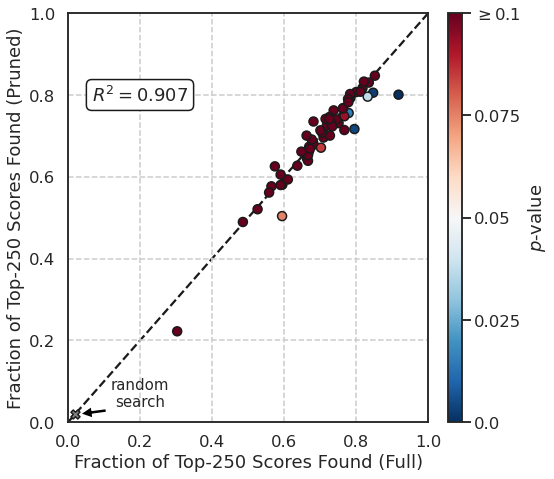

In [68]:
split = "0.004"
N = 5

fig = make_parity_plot(split, N)
fig.savefig(f"../figures/dockstring-parity-{split}-{N}.pdf", dpi=400)

## Bar charts

[back to top](#table-of-contents)

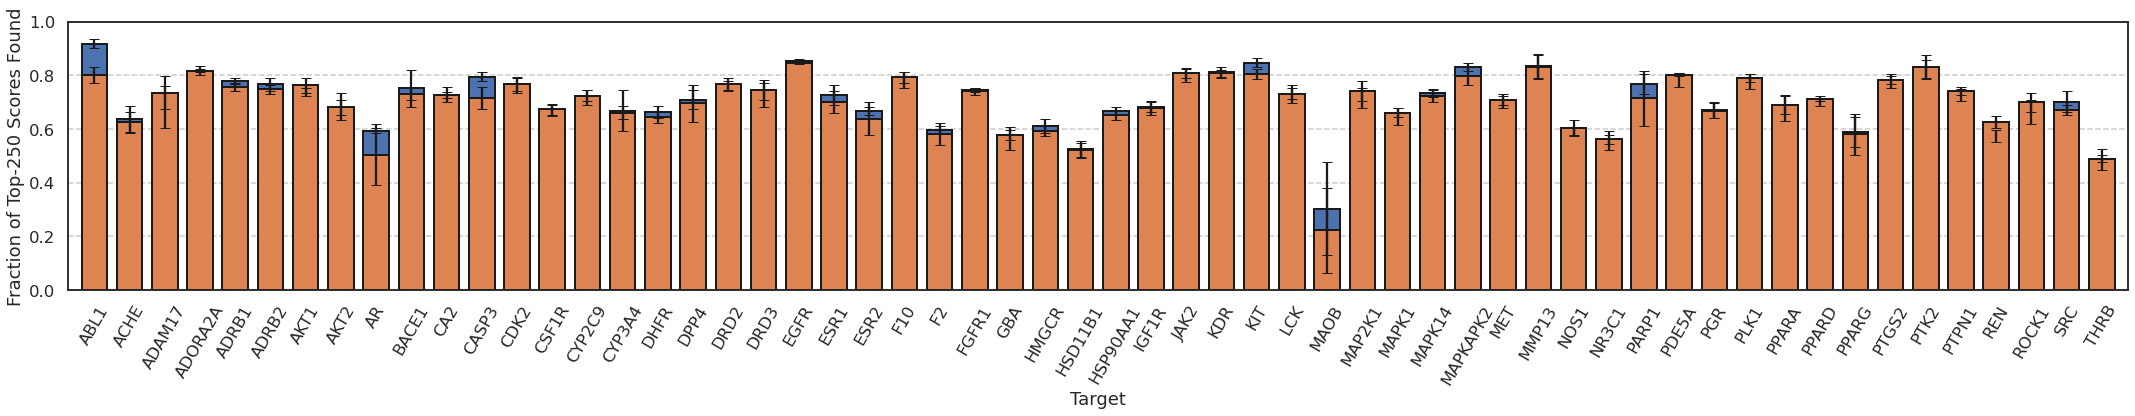

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(30, 6))

split = "0.004"
WIDTH = 0.725

Y_full, Y_prune, targets = get_dockstring_data(split, 5)
x = np.arange(len(targets))

ax.bar(
    x, Y_full[:, 0], WIDTH, yerr=Y_full[:, 1],
    capsize=5, ec='k', lw=2, label="full"
)
ax.bar(
    x, Y_prune[:, 0], WIDTH, yerr=Y_prune[:, 1],
    capsize=5, ec='k', lw=2, label="prune",
)

ax.set_xticks(x)
ax.set_xticklabels([target.upper() for target in targets], rotation=60)

ax.set_ylim(0, 1)
ax.set_xlim(-0.75, x[-1]+0.75)

ax.set_xlabel("Target")
ax.set_ylabel(f"Fraction of Top-250 Scores Found")

# ax.tick_params(axis="x", bottom=True)
ax.grid(axis="y", ls="--")

fig.tight_layout()

## CSVs

[back to top](#table-of-contents)

In [91]:
def make_dataframe(split, N) -> pd.DataFrame:
    Y_full, Y_prune, targets = get_dockstring_data(split, N)

    df = pd.DataFrame(
        {
            "target": [t.upper() for t in targets],
            "no pruning (mean)": Y_full[:, 0],
            "no pruning (s.d.)": Y_full[:, 1],
            "pruning (mean)": Y_prune[:, 0],
            "pruning (s.d.)": Y_prune[:, 1]
        },
    )

    return df

In [94]:
split = "0.001"
N = 10

df = make_dataframe(split, N)
df.to_csv(f"../csv/dockstring-final-{split}-{N}.csv", index=False, float_format="%.3f")

## Miscellaneous

In [ ]:
def make_prune_example(
    seed: int = 0, hit_cutoff: float = 1.0, prune_cutoff: float = 0., prob: bool = False
):
    np.random.seed(seed)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params("y", direction="inout", left="on")

    ax.set_ylabel(r"$\hat{y}$")
    ax.set_xlabel("Candidates")

    x = np.linspace(0, 1, 6)
    y_pred = np.random.normal(0, 2, size=len(x))
    y_sd = np.random.uniform(2, 2.5, size=len(x))

    ax.scatter(
        x, y_pred, c=y_pred, cmap="RdBu_r", edgecolors="k", linewidths=1.0, zorder=10
    )
    if not prob:
        ax.errorbar(x, y_pred, y_sd, capsize=3, capthick=2., ls="None", c="grey")
    else:
        data = [np.random.normal(m, sd, 10000) for m, sd in zip(y_pred, y_sd)]
        violin = ax.violinplot(
            data,
            x,
            True,
            widths=0.1,
            showmeans=False,
            showextrema=False,
            showmedians=False,
        )
        for pc in violin["bodies"]:
            pc.set_facecolor("m")
            pc.set_edgecolor("k")

    # hit_cutoff = 1.425
    ax.axhline(hit_cutoff, linestyle="--", c="r")
    ax.annotate(
        "predicted hit\nthreshold",
        xy=(0.52, hit_cutoff),
        xytext=(0.59, hit_cutoff + 3.75),
        arrowprops=dict(facecolor="black", shrink=0.05),
        wrap=True
    )

    if not prob:
        ax.axhline(prune_cutoff, linestyle="--", c="b")
        ax.annotate(
            "prune cutoff",
            xy=(0.8, prune_cutoff),
            xytext=(0.75, prune_cutoff+1.5),
            arrowprops=dict(facecolor="black", shrink=0.05),
            horizontalalignment="center",
            verticalalignment="bottom",
        )
        
    return fig


In [ ]:
make_prune_example(6, 3, prob=True).savefig("../figures/pruning/prune-prob-ex.pdf")